# Advanced 3D language

GeoLIPI can be used to also define primitives as used in [GeoCODE](https://threedle.github.io/GeoCode/), [SIF](https://arxiv.org/abs/1904.06447), and other 2D-to-3D operators (extrusions/revolutions etc.). This notebook shows examples of such primitives in action.

In [1]:
import sys
sys.path.append('../')

import numpy as np
import torch as th
import matplotlib.pyplot as plt

import geolipi.symbolic as gls
from geolipi.torch_compute.sphere_marcher import Renderer

dtype = th.float32
device = th.device("cuda")
resolution = (512, 256)


In [2]:
# Just use the default settings in the renderer
renderer = Renderer(resolution=resolution, dtype=dtype, device=device)


(-0.5, 511.5, 255.5, -0.5)

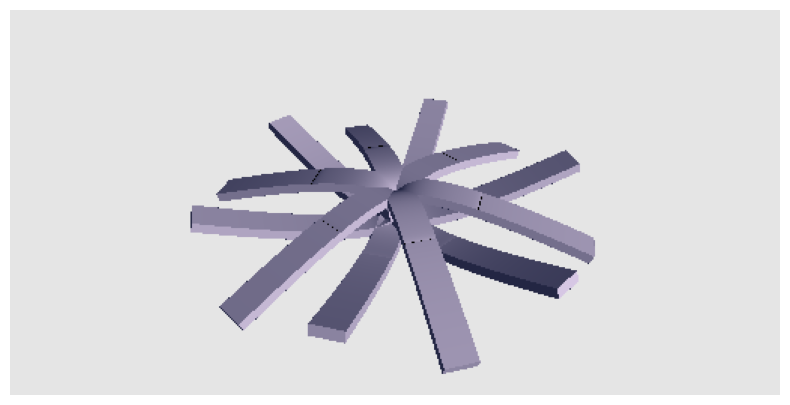

In [3]:
# Advanced Primitives: Extrusion based primitives.
expr_set = []
p1 = (0.1, 0.3)
p2 = (-0, 0, 0)
p3 = (-0, -2, 0.0)
for i in range(6):
    j = i + 1
    dist = 2#  * j
    theta = np.pi / 3  * j
    x = dist * np.cos(theta)
    y = dist * np.sin(theta)

    expression = gls.QuadraticBezierExtrude3D(
                    gls.Box2D(p1),
                    p2,
                    (0, 0.5, 0),
                    (x, -0.2, y),
                    (0,))
    expr_set.append(expression)

    theta = np.pi/6 + np.pi / 3  * j
    x = dist * np.cos(theta)
    y = dist * np.sin(theta)
    expression = gls.QuadraticBezierExtrude3D(
                    gls.Box2D(p1),
                    p2,
                    (0, -0.5, 0),
                    (-x, 0.2, -y),
                    (0,))
    expr_set.append(expression)

expression = gls.Union(*expr_set)

expression = expression.to_tensor().cuda()

image = renderer.render(expression)
plt.figure(figsize=(10, 5))
plt.imshow(image.detach().cpu().numpy())
plt.axis('off')


Erode3D(
	Translate3D(
		Union(
			InexactAnisotropicGaussian3D(tensor([0.5000, 0.0000, 0.0000], device='cuda:0'), tensor([0.1000, 0.1000, 0.1000], device='cuda:0'), tensor([-1.], device='cuda:0')),
			InexactAnisotropicGaussian3D(tensor([0.4854, 0.0000, 0.3527], device='cuda:0'), tensor([0.1000, 0.1000, 0.1000], device='cuda:0'), tensor([-1.], device='cuda:0')),
			InexactAnisotropicGaussian3D(tensor([0.2163, 0.0000, 0.6657], device='cuda:0'), tensor([0.1000, 0.1000, 0.1000], device='cuda:0'), tensor([-1.], device='cuda:0')),
			InexactAnisotropicGaussian3D(tensor([-0.2472,  0.0000,  0.7608], device='cuda:0'), tensor([0.1000, 0.1000, 0.1000], device='cuda:0'), tensor([-1.], device='cuda:0')),
			InexactAnisotropicGaussian3D(tensor([-0.7281,  0.0000,  0.5290], device='cuda:0'), tensor([0.1000, 0.1000, 0.1000], device='cuda:0'), tensor([-1.], device='cuda:0')),
			InexactAnisotropicGaussian3D(tensor([-1.0000e+00,  0.0000e+00,  1.2246e-16], device='cuda:0'), tensor([0.1000, 0.1000, 0.100

(-0.5, 511.5, 255.5, -0.5)

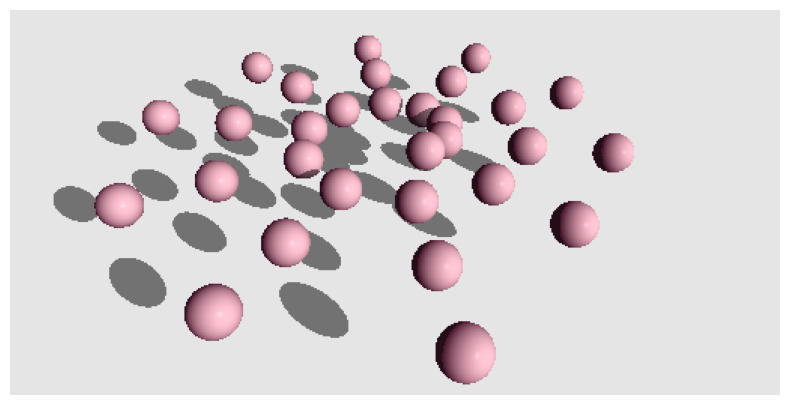

In [14]:
# Advanced Primitive: Gaussian based
expr_set = []
for i in range(30):
    position = 0.5 + i * 0.1
    theta = np.pi / 5 * i
    size = (0.1, 0.1)
    expr = gls.InexactAnisotropicGaussian3D(
        (position * np.cos(theta), 0, position * np.sin(theta)),
        (size[0], 0.1, size[1]),
        (-1,))
    expr_set.append(expr)

expr = gls.Translate3D(gls.Union(*expr_set), (-1, 0, 1))
expr = gls.Erode3D(expr, 0.07)
# expr = gls.Sphere3D((0.1,))
expr = expr.to_tensor().cuda()
print(expr.pretty_print())
image = renderer.render(expr,)
plt.figure(figsize=(10, 5))
plt.imshow(image.detach().cpu().numpy())
plt.axis('off')


EulerRotate3D(
	Revolution3D(
		Circle2D(tensor([0.2000], device='cuda:0')),
		tensor(1.2000, device='cuda:0')),
	tensor([1.5708, 0.0000, 0.0000], device='cuda:0'))


(-0.5, 511.5, 255.5, -0.5)

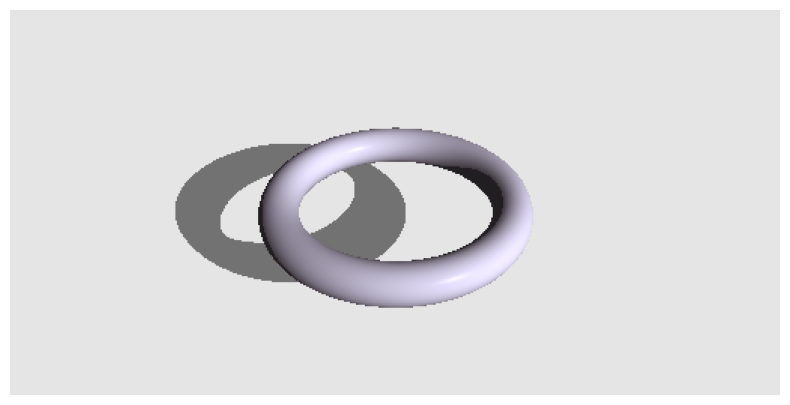

In [11]:
# Advanced Primitive: Revolution & Extrusion of 2D SDFs.

expr = gls.Circle2D((0.2,))
# expr = gls.SimpleExtrusion3D(expr, (0.7))
expr = gls.Revolution3D(expr, (1.2))
expr = gls.EulerRotate3D(expr, (np.pi/2, 0, 0))
expr = expr.to_tensor().cuda()

print(expr.pretty_print())
image = renderer.render(expr,)
plt.figure(figsize=(10, 5))
plt.imshow(image.detach().cpu().numpy())
plt.axis('off')